# Text-only

In [21]:
import pandas as pd
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import pickle


def svm_func(df):

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)
    X_train = df_train['motivation']
    y_train = df_train['bsa_dummy']
    X_test = df_test['motivation']
    y_test = df_test['bsa_dummy']

 
    stopword_list = list(stopwords.words('Dutch'))

    pipe = make_pipeline(TfidfVectorizer(lowercase=True, stop_words=stopword_list), SVC(class_weight='balanced'))
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.7082153  0.70727101 0.70443815 0.70727101 0.70727101]
average of 5-fold cross validation scores: 0.7068932955618508
Accuracy for SVM on test_set: 0.7246458923512747
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1312
           1       0.43      0.24      0.31       453

    accuracy                           0.72      1765
   macro avg       0.60      0.57      0.57      1765
weighted avg       0.69      0.72      0.70      1765



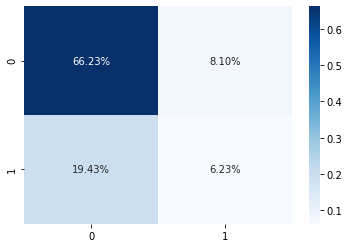

In [22]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
# df.dropna(subset=['bsa_dummy', 'motivation'], inplace=True)
df = df.fillna(method='ffill')

svm_func(df)


# Text-only: feature selection

In [19]:
import pandas as pd
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import pickle
from sklearn.feature_selection import SelectFromModel


def svm_text_featureselection(df):

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)
    X_train = df_train['motivation']
    y_train = df_train['bsa_dummy']
    X_test = df_test['motivation']
    y_test = df_test['bsa_dummy']

 
    stopword_list = list(stopwords.words('Dutch'))

    pipe = make_pipeline(TfidfVectorizer(lowercase=True, stop_words=stopword_list),
                         SelectFromModel(LinearSVC(penalty="l1", dual=False)),
                         SVC(class_weight='balanced'))
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.66100094 0.67044381 0.67610954 0.65250236 0.67988669]
average of 5-fold cross validation scores: 0.6679886685552407
Accuracy for SVM on test_set: 0.6827195467422096
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1312
           1       0.37      0.34      0.35       453

    accuracy                           0.68      1765
   macro avg       0.57      0.57      0.57      1765
weighted avg       0.67      0.68      0.68      1765



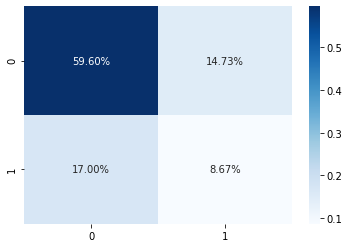

In [20]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
# df.dropna(subset=['bsa_dummy', 'motivation'], inplace=True)
df = df.fillna(method='ffill')
svm_text_featureselection(df)

# Initial numeric features

In [54]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression

    
def svm_initial_features(df):  
    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    target = df['bsa_dummy']
    df1 = df[categorical_features]
    df2 = df[numeric_features]
    df = pd.concat([df1, df2], axis=1)
    df = pd.concat([df, target], axis=1)

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)

    X_train = df_train.loc[:,df_train.columns !='bsa_dummy']
    y_train = df_train['bsa_dummy']
    X_test = df_test.loc[:,df_test.columns !='bsa_dummy']
    y_test = df_test['bsa_dummy']
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         SVC(class_weight='balanced'))
    
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


    
    

5-fold cross validation scores: [0.64683664 0.61945231 0.63739377 0.63644948 0.64494806]
average of 5-fold cross validation scores: 0.6370160528800756
Accuracy for SVM on test_set: 0.6345609065155807
              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1312
           1       0.38      0.64      0.47       453

    accuracy                           0.63      1765
   macro avg       0.61      0.64      0.60      1765
weighted avg       0.72      0.63      0.66      1765



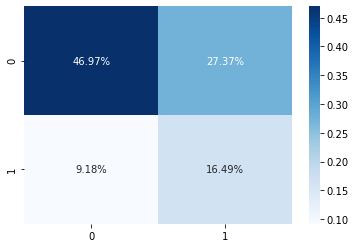

In [55]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

svm_initial_features(df)

# Added features + initial features- only numeric and categorical

In [58]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression

    
def svm_all_nontext_features(df):
    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                            'Dic', 'funct', 'pronoun', 'ppron', 'i',
                            'we', 'you', 'shehe', 'they', 'ipron',
                            'article', 'verb', 'auxverb', 'past', 'present',
                            'future', 'adverb', 'preps', 'conj', 'negate',
                            'quant', 'number', 'swear', 'social', 'family',
                            'friend', 'humans', 'affect', 'posemo', 'negemo',
                            'anx', 'anger', 'sad', 'cogmech', 'insight',
                            'cause', 'discrep', 'tentat', 'certain', 'inhib',
                            'incl', 'excl', 'percept', 'see', 'hear',
                            'feel', 'bio', 'body', 'health', 'sexual',
                            'ingest', 'relativ', 'motion', 'space', 'time',
                            'work', 'achieve', 'leisure', 'home', 'money',
                            'relig', 'death', 'assent', 'nonfl', 'filler',
                            'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                            'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                            'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                            'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                            'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                            'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                            'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                            'topic15']

    # Change object (string) type of features to float
    change_type = ['WPS', 'Sixltr',
                       'Dic', 'funct', 'pronoun', 'ppron', 'i',
                       'we', 'you', 'shehe', 'they', 'ipron',
                       'article', 'verb', 'auxverb', 'past', 'present',
                       'future', 'adverb', 'preps', 'conj', 'negate',
                       'quant', 'number', 'swear', 'social', 'family',
                       'friend', 'humans', 'affect', 'posemo', 'negemo',
                       'anx', 'anger', 'sad', 'cogmech', 'insight',
                       'cause', 'discrep', 'tentat', 'certain', 'inhib',
                       'incl', 'excl', 'percept', 'see', 'hear',
                       'feel', 'bio', 'body', 'health', 'sexual',
                       'ingest', 'relativ', 'motion', 'space', 'time',
                       'work', 'achieve', 'leisure', 'home', 'money',
                       'relig', 'death', 'assent', 'nonfl', 'filler',
                       'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                       'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                       'Quote', 'Apostro', 'Parenth', 'OtherP']
    df[change_type] = df[change_type].apply(lambda x: x.str.replace(',', '.'))
    df[change_type] = df[change_type].astype(float).fillna(0.0)

    target = df['bsa_dummy']

    df1 = df[categorical_features]
    df2 = df[numeric_features]
    df = pd.concat([df1, df2], axis=1)
    df = pd.concat([df, target], axis=1)

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)

    X_train = df_train.loc[:,df_train.columns !='bsa_dummy']
    y_train = df_train['bsa_dummy']
    X_test = df_test.loc[:,df_test.columns !='bsa_dummy']
    y_test = df_test['bsa_dummy']
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         SVC(class_weight='balanced'))
    
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.65061379 0.64872521 0.66666667 0.64305949 0.66288952]
average of 5-fold cross validation scores: 0.6543909348441926
Accuracy for SVM on test_set: 0.6577903682719547
              precision    recall  f1-score   support

           0       0.80      0.71      0.76      1312
           1       0.37      0.49      0.43       453

    accuracy                           0.66      1765
   macro avg       0.59      0.60      0.59      1765
weighted avg       0.69      0.66      0.67      1765



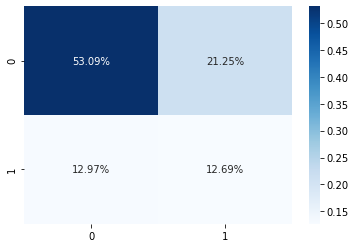

In [59]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

svm_all_nontext_features(df)

# Text + Initial non-textual features

In [99]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

    
def svm_text_initial_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
            ]))
        ])),


        ('clf', SVC(class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    df_features =pd.concat([text,num], axis=1)
    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


    
    


5-fold cross validation scores: [0.63078376 0.62983947 0.65061379 0.66100094 0.62983947]
average of 5-fold cross validation scores: 0.6404154863078375
Accuracy for SVM on test_set: 0.6317280453257791
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1312
           1       0.37      0.60      0.45       453

    accuracy                           0.63      1765
   macro avg       0.59      0.62      0.59      1765
weighted avg       0.71      0.63      0.65      1765



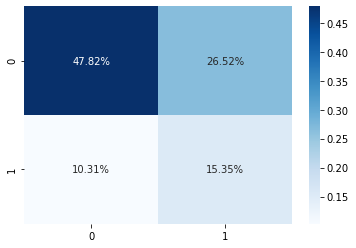

In [100]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')


svm_text_initial_features(df)

In [109]:
def svm_text_initial_features2(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
            ]))
        ])),


        ('clf', SVC(class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
#     num = df[numeric_features]
    cat = df[categorical_features]
#     df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([text,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.63456091 0.6279509  0.63172805 0.64683664 0.63833805]
average of 5-fold cross validation scores: 0.6358829084041548
Accuracy for SVM on test_set: 0.6379603399433428
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1312
           1       0.37      0.56      0.44       453

    accuracy                           0.64      1765
   macro avg       0.59      0.61      0.59      1765
weighted avg       0.70      0.64      0.66      1765



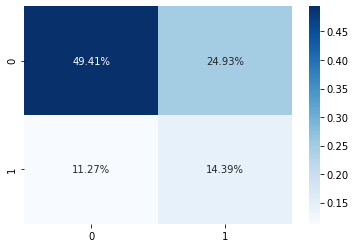

In [110]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')


svm_text_initial_features2(df)

In [111]:
def svm_text_initial_features3(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
            ]))
        ])),


        ('clf', SVC(class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.65439093 0.62983947 0.64778093 0.65439093 0.65627951]
average of 5-fold cross validation scores: 0.6485363550519357
Accuracy for SVM on test_set: 0.6532577903682719
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1312
           1       0.39      0.64      0.49       453

    accuracy                           0.65      1765
   macro avg       0.62      0.65      0.61      1765
weighted avg       0.73      0.65      0.67      1765



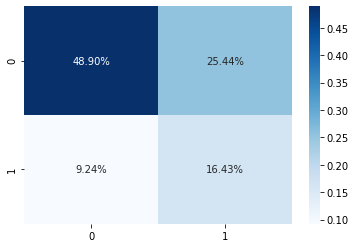

In [112]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')


svm_text_initial_features3(df)

# Text + all numeric and categorical features

In [119]:
def svm_all_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                        'Dic', 'funct', 'pronoun', 'ppron', 'i',
                        'we', 'you', 'shehe', 'they', 'ipron',
                        'article', 'verb', 'auxverb', 'past', 'present',
                        'future', 'adverb', 'preps', 'conj', 'negate',
                        'quant', 'number', 'swear', 'social', 'family',
                        'friend', 'humans', 'affect', 'posemo', 'negemo',
                        'anx', 'anger', 'sad', 'cogmech', 'insight',
                        'cause', 'discrep', 'tentat', 'certain', 'inhib',
                        'incl', 'excl', 'percept', 'see', 'hear',
                        'feel', 'bio', 'body', 'health', 'sexual',
                        'ingest', 'relativ', 'motion', 'space', 'time',
                        'work', 'achieve', 'leisure', 'home', 'money',
                        'relig', 'death', 'assent', 'nonfl', 'filler',
                        'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                        'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                        'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                        'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                        'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                        'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                        'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                        'topic15']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list)),
                ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False)))
            ]))
        ])),


        ('clf', SVC(class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.64400378 0.61189802 0.64872521 0.64589235 0.64589235]
average of 5-fold cross validation scores: 0.6392823418319169
Accuracy for SVM on test_set: 0.6453257790368272
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1312
           1       0.38      0.59      0.46       453

    accuracy                           0.65      1765
   macro avg       0.60      0.63      0.60      1765
weighted avg       0.71      0.65      0.67      1765



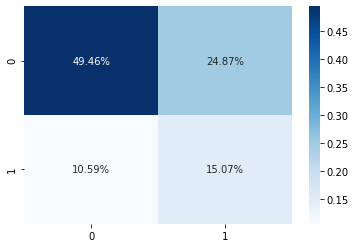

In [120]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
change_type = ['WPS', 'Sixltr',
                   'Dic', 'funct', 'pronoun', 'ppron', 'i',
                   'we', 'you', 'shehe', 'they', 'ipron',
                   'article', 'verb', 'auxverb', 'past', 'present',
                   'future', 'adverb', 'preps', 'conj', 'negate',
                   'quant', 'number', 'swear', 'social', 'family',
                   'friend', 'humans', 'affect', 'posemo', 'negemo',
                   'anx', 'anger', 'sad', 'cogmech', 'insight',
                   'cause', 'discrep', 'tentat', 'certain', 'inhib',
                   'incl', 'excl', 'percept', 'see', 'hear',
                   'feel', 'bio', 'body', 'health', 'sexual',
                   'ingest', 'relativ', 'motion', 'space', 'time',
                   'work', 'achieve', 'leisure', 'home', 'money',
                   'relig', 'death', 'assent', 'nonfl', 'filler',
                   'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                   'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                   'Quote', 'Apostro', 'Parenth', 'OtherP']
df[change_type] = df[change_type].apply(lambda x: x.str.replace(',', '.'))
df[change_type] = df[change_type].astype(float).fillna(0.0)
svm_all_features(df)

# Text + all features excluding LIWC

In [121]:
def svm_without_liwc_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                        'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                        'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                        'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                        'topic15']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list)),
                ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False)))
            ]))
        ])),


        ('clf', SVC(class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.64400378 0.61189802 0.64872521 0.64589235 0.64589235]
average of 5-fold cross validation scores: 0.6392823418319169
Accuracy for SVM on test_set: 0.6453257790368272
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1312
           1       0.38      0.59      0.46       453

    accuracy                           0.65      1765
   macro avg       0.60      0.63      0.60      1765
weighted avg       0.71      0.65      0.67      1765



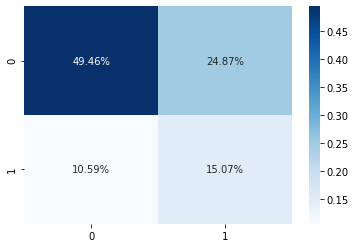

In [122]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

svm_all_without_liwc_features(df)